In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

raw_loans = pd.read_csv('loan.csv', dtype={47: str}, low_memory=False)

# number of columns and rows
print("Number of columns: ", len(raw_loans.columns))
print("Number of rows: ", len(raw_loans))

Number of columns:  111
Number of rows:  39717


#### Remove unnecessary rows
- Remove loans that are still in progress

In [2]:
# remove loans that are still in progress
loans = raw_loans[raw_loans['loan_status'] != 'Current']

#### Clean up of columns
- Drop columns with all null values
- Drop columns with all same values

In [3]:
# Drop columns with all NaN values
nan_cols = loans.columns[loans.isna().all()].tolist()
print(len(nan_cols), "collumns have null values in all rows, these columns can be dropped")
loans = loans.drop(nan_cols, axis=1)

# Drop columns with only one unique value
unique_value_cols = loans.columns[loans.nunique() == 1]
print(len(unique_value_cols), "columns have only one unique value, these columns can be dropped as they do not provide any useful information")
loans = loans.drop(unique_value_cols, axis=1)

# Left with columns data
print("\n")
print("Columns left: ", len(loans.columns))

55 collumns have null values in all rows, these columns can be dropped
11 columns have only one unique value, these columns can be dropped as they do not provide any useful information


Columns left:  45


#### Remove outliers
Columns to remove outliers on:
 - loan_amnt
- funded_amnt
- annual_inc

In [4]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    filter = (df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 *IQR)
    return df.loc[filter]

# remove outliers
loans = remove_outliers(loans, 'loan_amnt')
loans = remove_outliers(loans, 'funded_amnt')
loans = remove_outliers(loans, 'annual_inc')

#### Add new columns
- Add column for loan status (0 = not default, 1 = default)
- Add column for loan term (0 = 36 months, 1 = 60 months)
- Add column for loan grade (A-G)
- Add column for loan subgrade (1-5)
- Add column for loan home ownership (1-6)
- Add column for loan verification status (1-3)

- Add column for loan issue month (1-12)
- Add column for loan issue year (2007-2015)

- Add column for loan interest rate (0-30)

- Add column for percent funded (0-100)
- Add column for binning of percent funded (0-100)

- Add column for percent funded by investors (0-100)
- Add column for binning of percent funded by investors (0-100)

In [5]:
# add a new column to indicate if the loan is fully paid or not ( 0 - fully paid, 1 - defaulted)
loans['default'] = np.where(loans['loan_status'].isin(['Fully Paid']), 0, 1)

loans['term_num'] = np.where(loans['term'].isin([' 36 months']), 0, 1)

# convert issue_d to datetime
loans['issue_d'] = pd.to_datetime(loans['issue_d'], format='%b-%y')
loans['issue_month'] = loans['issue_d'].dt.month
loans['issue_year'] = loans['issue_d'].dt.year

# convert earliest_cr_line to datetime
loans['earliest_cr_line'] = pd.to_datetime(loans['earliest_cr_line'], format='%b-%y')

# convert last_pymnt_d to datetime
loans['last_pymnt_d'] = pd.to_datetime(loans['last_pymnt_d'], format='%b-%y')

# convert last_credit_pull_d to datetime
loans['last_credit_pull_d'] = pd.to_datetime(loans['last_credit_pull_d'], format='%b-%y')

# convert loan grade to numeric
loans['grade_num'] = loans['grade'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})

# convert loan sub grade to numeric
loans['sub_grade_num'] = loans['sub_grade'].map({'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5,
                                                    'B1': 6, 'B2': 7, 'B3': 8, 'B4': 9, 'B5': 10,
                                                    'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 'C5': 15,
                                                    'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20,
                                                    'E1': 21, 'E2': 22, 'E3': 23, 'E4': 24, 'E5': 25,
                                                    'F1': 26, 'F2': 27, 'F3': 28, 'F4': 29, 'F5': 30,
                                                    'G1': 31, 'G2': 32, 'G3': 33, 'G4': 34, 'G5': 35})

# convert loan sub grade to numeric
loans['emp_length_num'] = loans['emp_length'].map({'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
                                                    '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9,
                                                    '10+ years': 10})

# convert loan grade and sub grade to combined numeric
loans['grade_sub_grade_num'] = loans['grade_num'] * 100 + loans['sub_grade_num'] * 20

# convert int_rate to numeric
loans['int_rate_num'] = loans['int_rate'].str.rstrip('%').astype('float')


#### Important columns information:

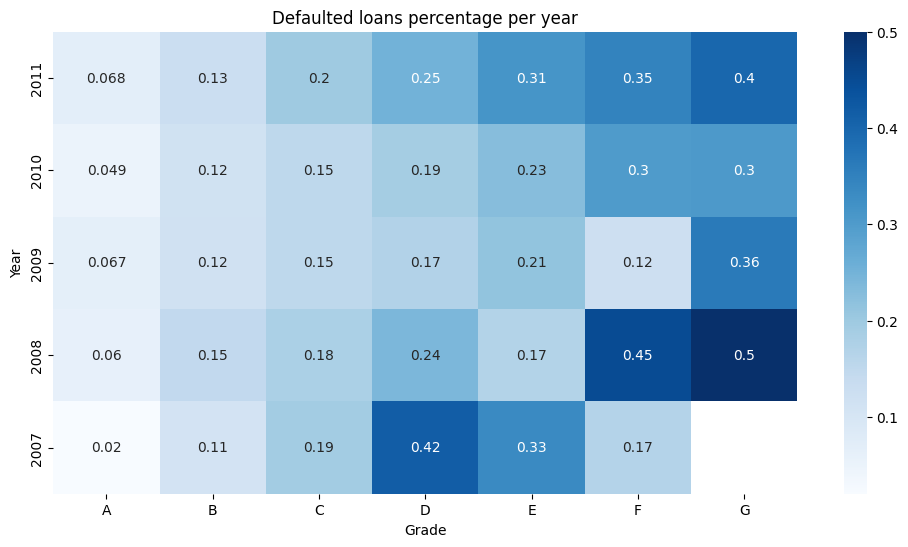

In [6]:
# draw a heatmap of defaulted loans percentage per year
plt.figure(figsize=(12, 6))
df = loans.groupby(['issue_year', 'grade_num']).agg({'default': 'mean'}).reset_index()
df = df.pivot(index='issue_year', columns='grade_num', values='default')
df = df.sort_index(ascending=False)
sns.heatmap(df, annot=True, cmap='Blues')
plt.xticks(np.arange(0.5, 7.5, 1), ['A', 'B', 'C', 'D', 'E', 'F', 'G'])
plt.xlabel('Grade')
plt.ylabel('Year')
plt.title('Defaulted loans percentage per year')
plt.show()

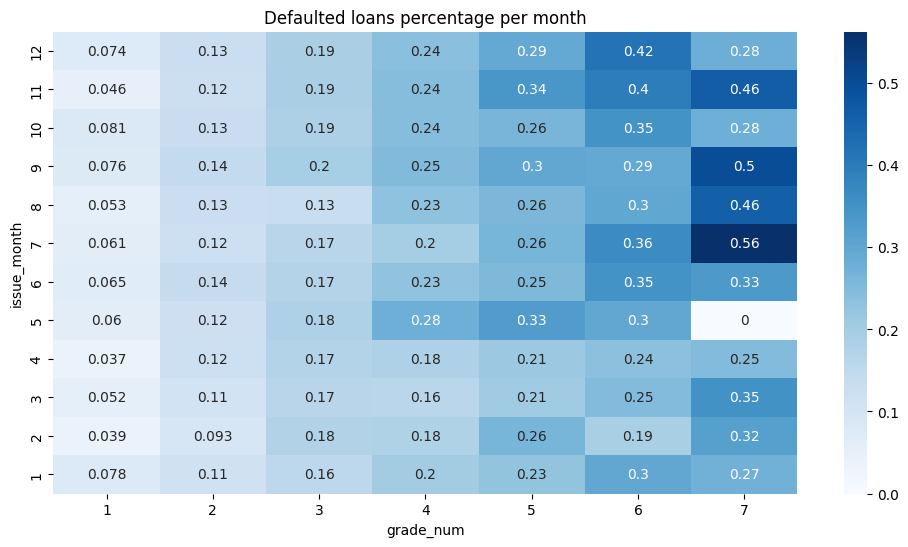

In [7]:
# draw a heatmap of defaulted loans percentage per month
plt.figure(figsize=(12, 6))
df = loans.groupby(['issue_month', 'grade_num']).agg({'default': 'mean'}).reset_index()
df = df.pivot(index='issue_month', columns='grade_num', values='default')
df = df.sort_index(ascending=False)
sns.heatmap(df, annot=True, cmap='Blues')
plt.title('Defaulted loans percentage per month')
plt.show()

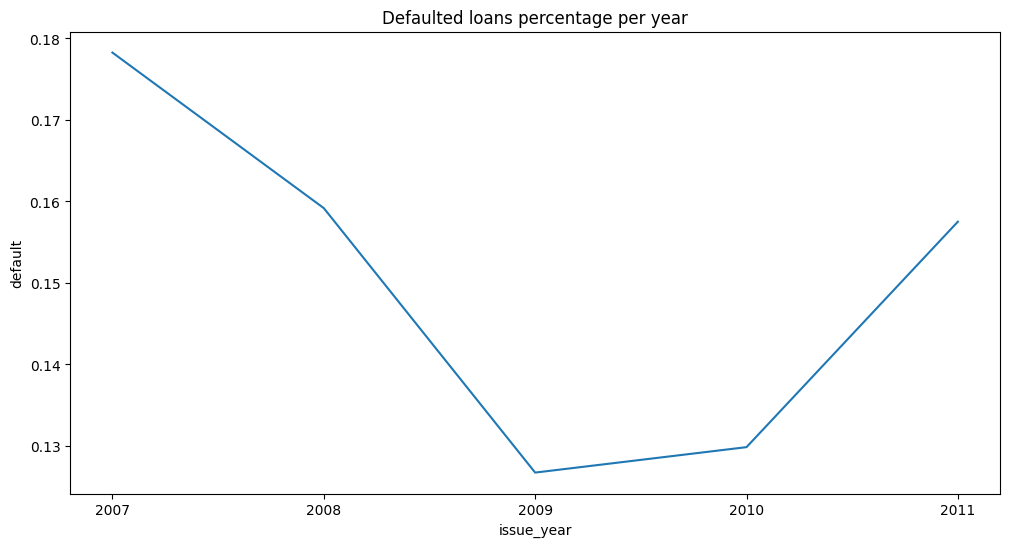

In [8]:
# draw line chart of defaulted loans percentage per year
plt.figure(figsize=(12, 6))
df = loans.groupby(['issue_year']).agg({'default': 'mean'}).reset_index()
sns.lineplot(x='issue_year', y='default', data=df)
plt.xticks(df['issue_year'])
plt.title('Defaulted loans percentage per year')
plt.show()

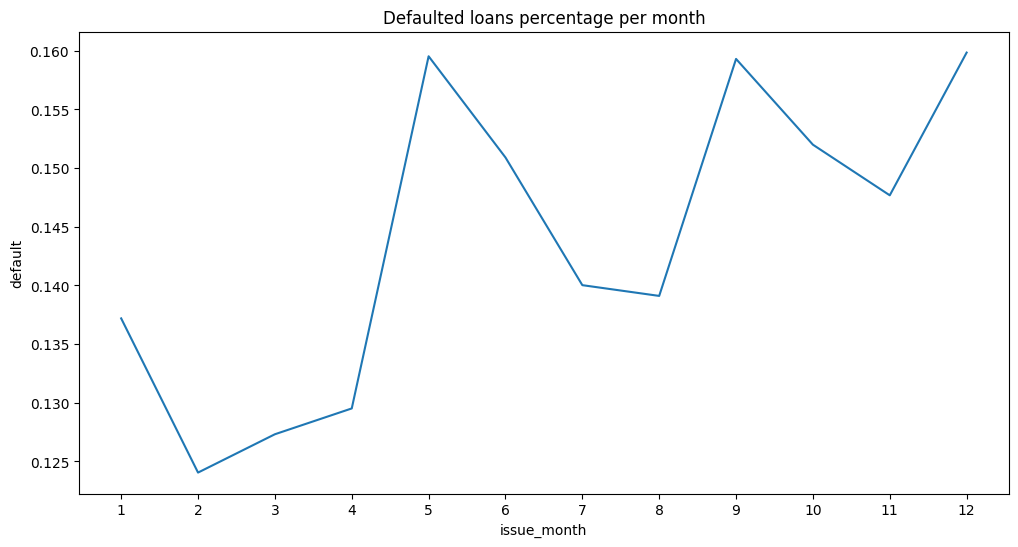

In [9]:
# draw line chart of defaulted loans percentage per month
plt.figure(figsize=(12, 6))
df = loans.groupby(['issue_month']).agg({'default': 'mean'}).reset_index()
sns.lineplot(x='issue_month', y='default', data=df)
plt.xticks(df['issue_month'])
plt.title('Defaulted loans percentage per month')
plt.show()

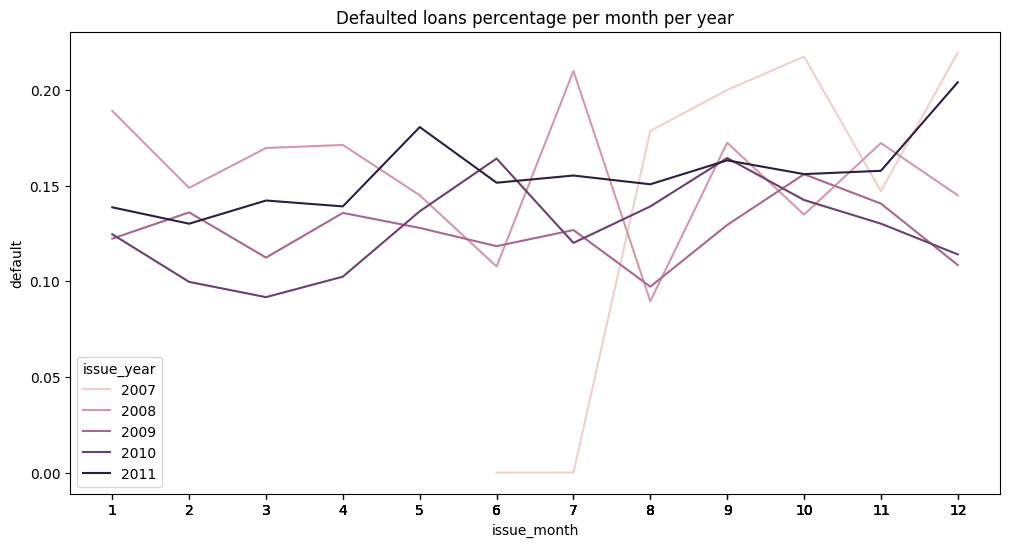

In [10]:
# draw line chart of defaulted loans percentage per month per year
plt.figure(figsize=(12, 6))
df = loans.groupby(['issue_year', 'issue_month']).agg({'default': 'mean'}).reset_index()
sns.lineplot(x='issue_month', y='default', hue='issue_year', data=df)
plt.xticks(df['issue_month'])
plt.title('Defaulted loans percentage per month per year')
plt.show()

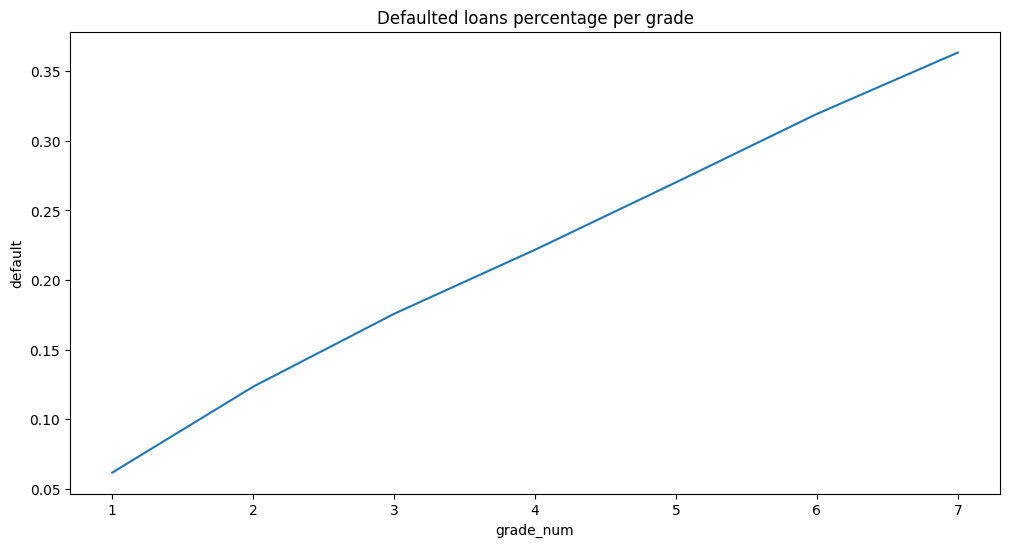

In [11]:
# draw line chart of defaulted loans percentage per grade
plt.figure(figsize=(12, 6))
df = loans.groupby(['grade_num']).agg({'default': 'mean'}).reset_index()
sns.lineplot(x='grade_num', y='default', data=df)
plt.xticks(df['grade_num'])
plt.title('Defaulted loans percentage per grade')
plt.show()

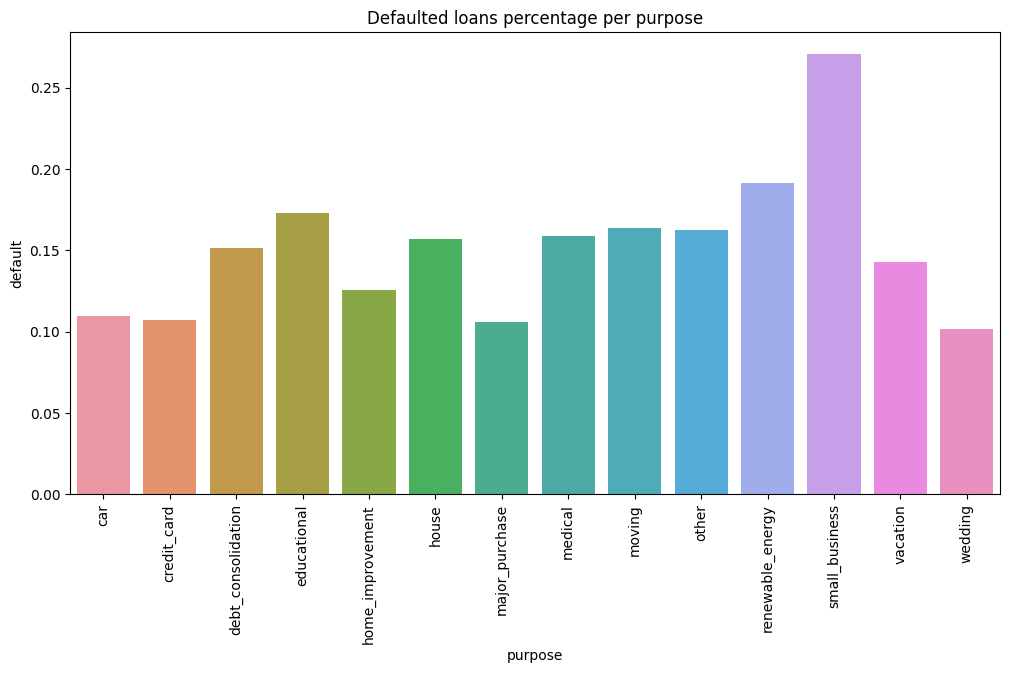

In [12]:
# draw loan default percentage per purpose
plt.figure(figsize=(12, 6))
df = loans.groupby(['purpose']).agg({'default': 'mean'}).reset_index()
sns.barplot(x='purpose', y='default', data=df)
plt.xticks(rotation=90)
plt.title('Defaulted loans percentage per purpose')
plt.show()

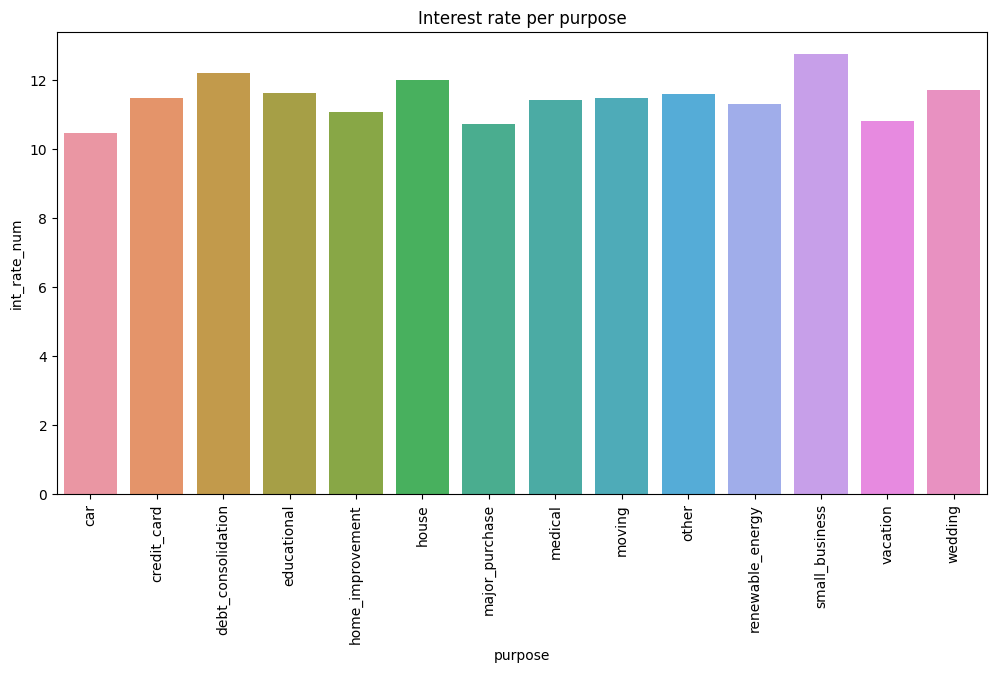

In [13]:
# draw interest rate per purpose
plt.figure(figsize=(12, 6))
df = loans.groupby(['purpose']).agg({'int_rate_num': 'mean'}).reset_index()
sns.barplot(x='purpose', y='int_rate_num', data=df)
plt.xticks(rotation=90)
plt.title('Interest rate per purpose')
plt.show()

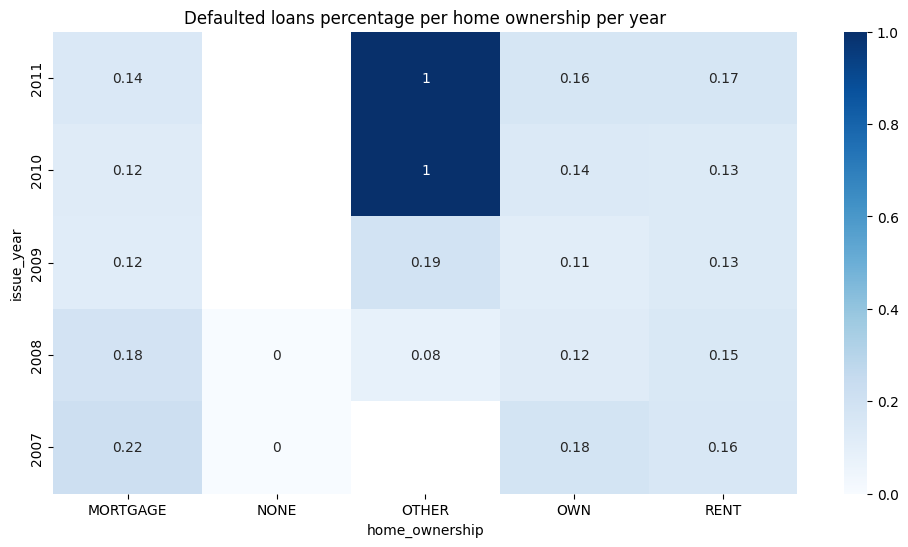

In [14]:
# draw heat map of default percentage per home ownership per year
plt.figure(figsize=(12, 6))
df = loans.groupby(['issue_year', 'home_ownership']).agg({'default': 'mean'}).reset_index()
df = df.pivot(index='issue_year', columns='home_ownership', values='default')
df = df.sort_index(ascending=False)
sns.heatmap(df, annot=True, cmap='Blues')
plt.title('Defaulted loans percentage per home ownership per year')
plt.show()


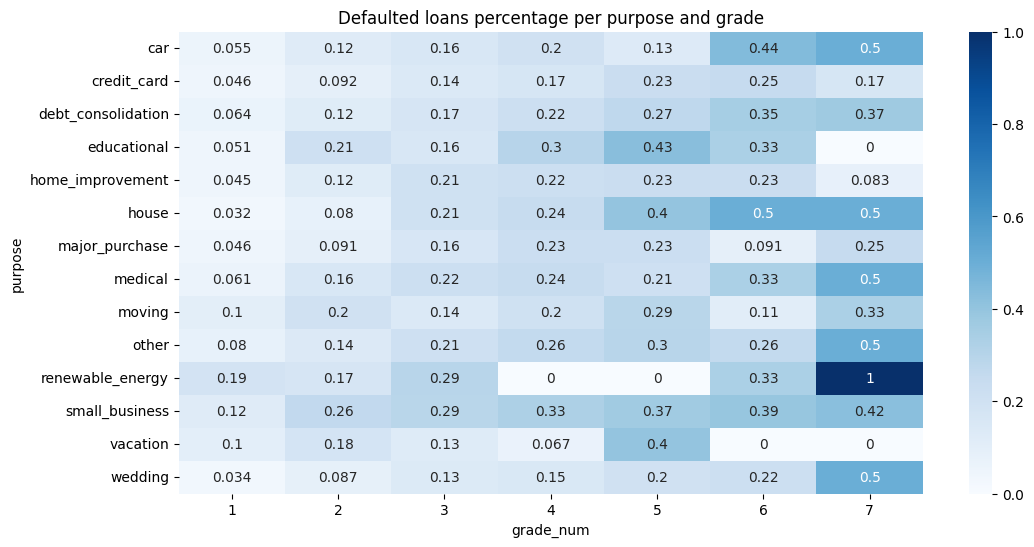

In [15]:
# draw heatmap of loan default percentage per purpose and grade
plt.figure(figsize=(12, 6))
df = loans.groupby(['purpose', 'grade_num']).agg({'default': 'mean'}).reset_index()
df = df.pivot(index='purpose', columns='grade_num', values='default')
sns.heatmap(df, annot=True, cmap='Blues')
plt.title('Defaulted loans percentage per purpose and grade')
plt.show()

Number of numerical columns:  34


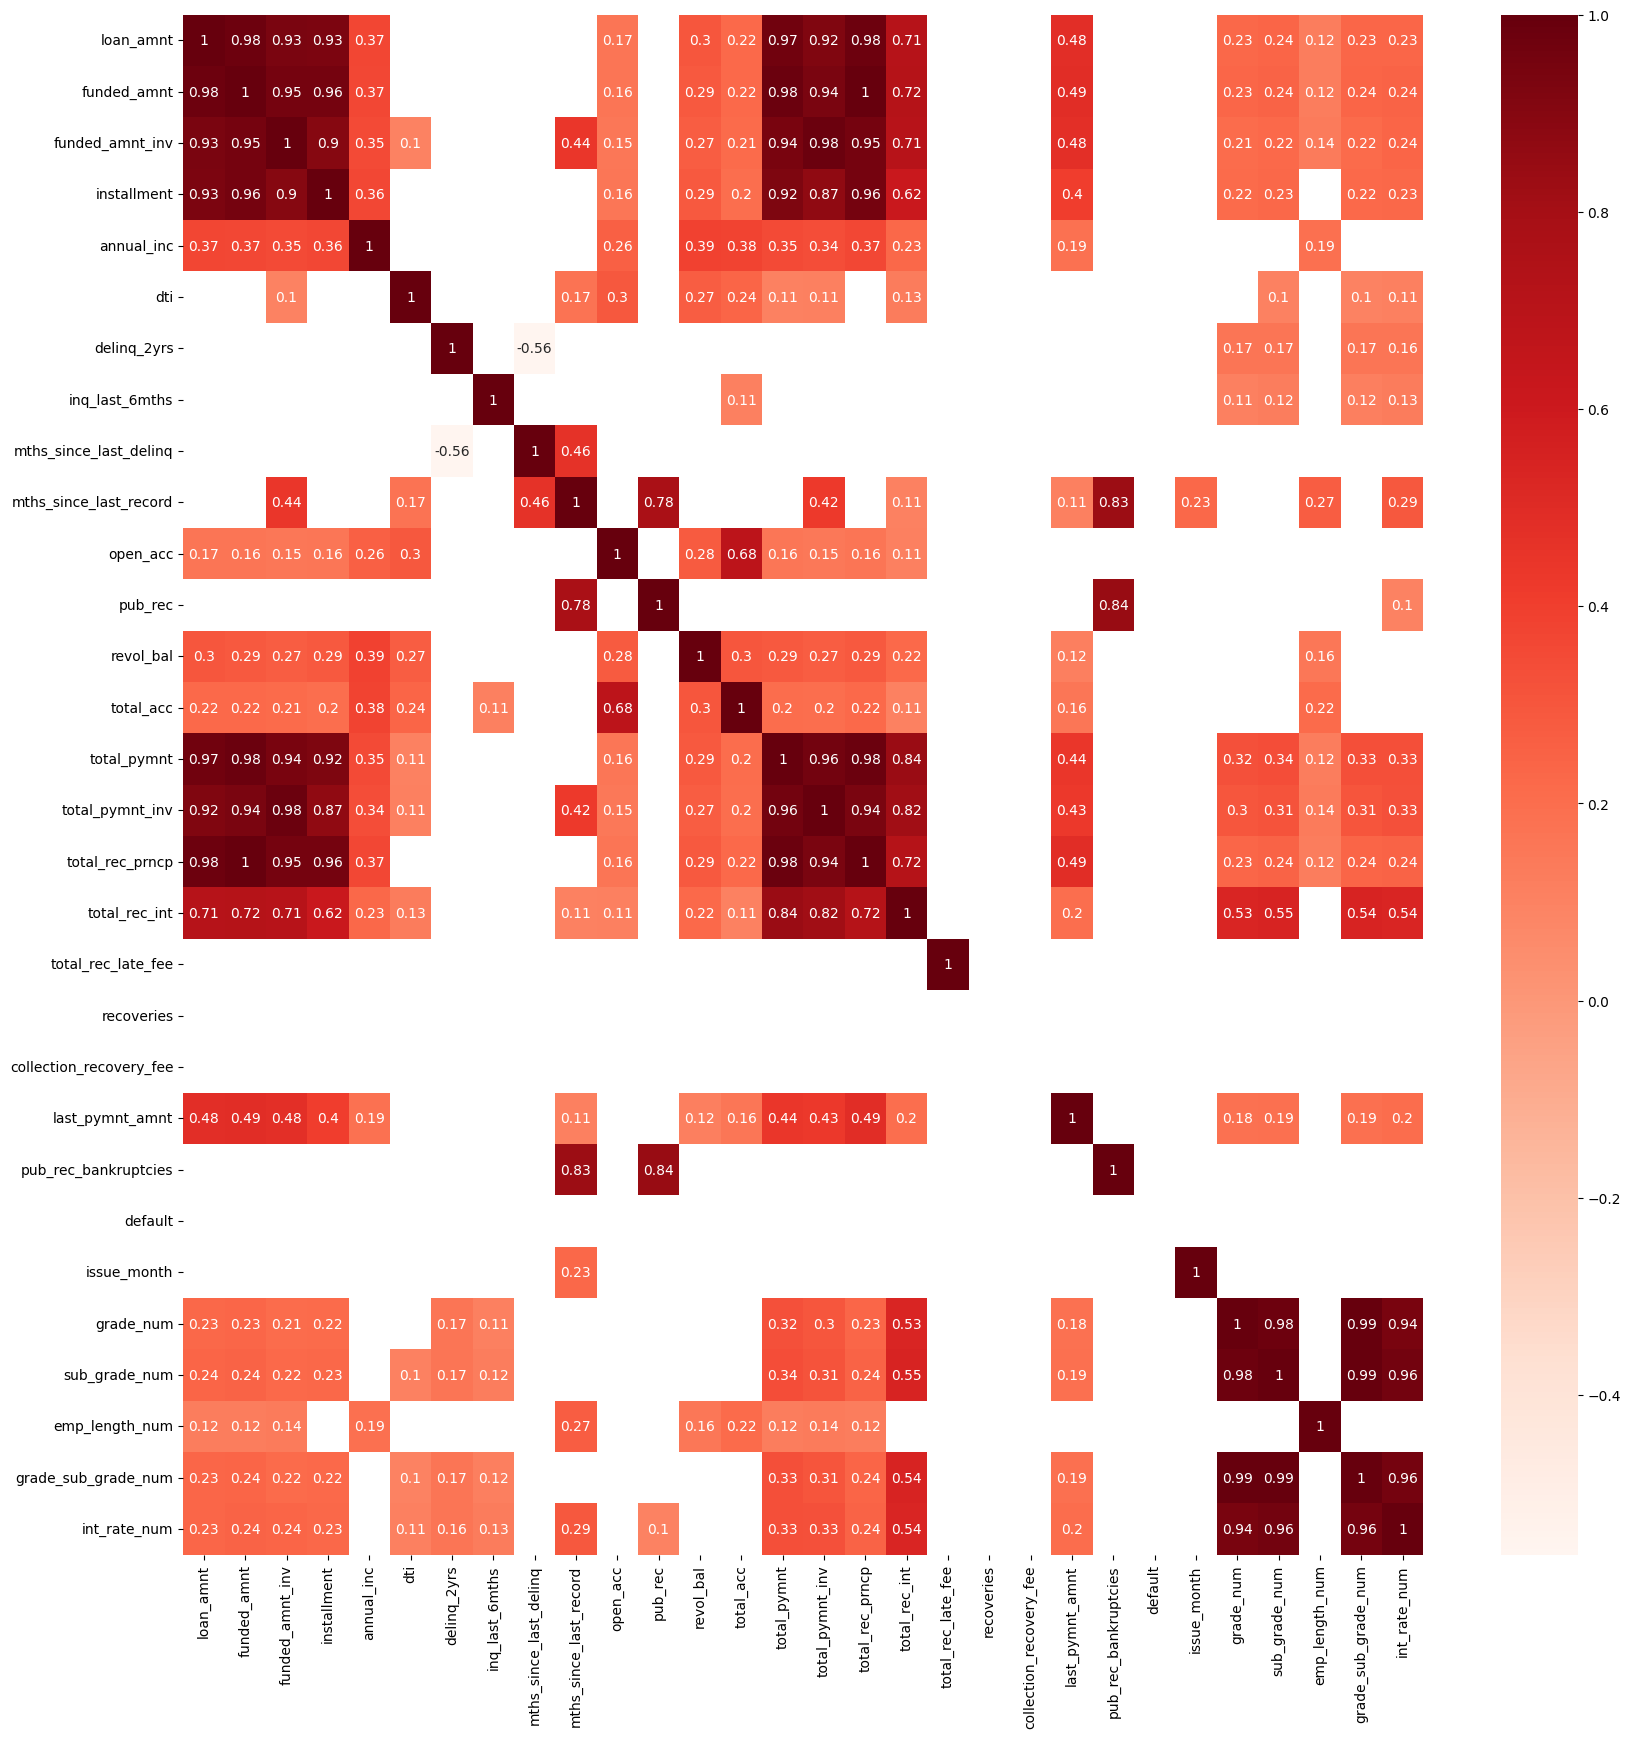

In [16]:
numerical_cols = loans[loans['loan_status'] == 'Fully Paid'].select_dtypes(include=[np.number])
print("Number of numerical columns: ", len(numerical_cols.columns))

cols_to_ignore = ['id', 'member_id', 'term_num', 'issue_year']

numerical_cols.drop(cols_to_ignore, axis=1, inplace=True)

corr_matrix = numerical_cols.corr()
# print(corr_matrix)

# plot correlation matrix
# Replace values below the threshold with NaN
threshold = 0.1
corr_matrix[abs(corr_matrix) < threshold] = np.nan
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

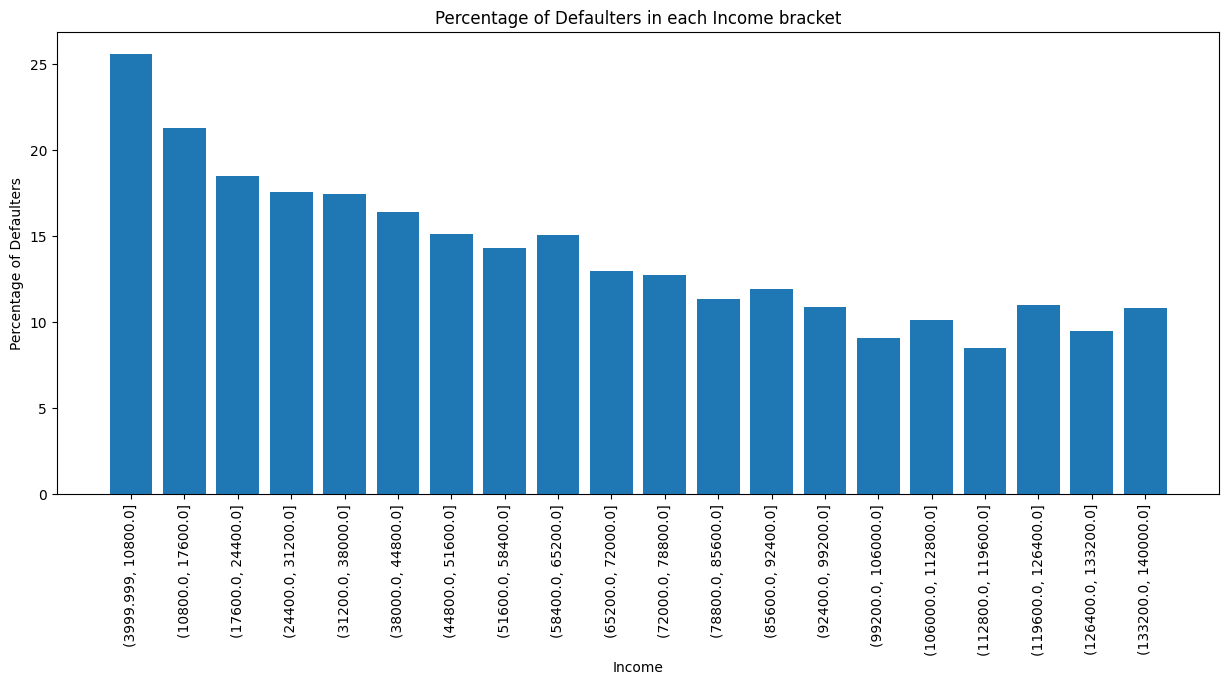

In [17]:
# sns.boxplot(x='loan_status', y='annual_inc', data=loans, showfliers=False)
# plt.show()

df = loans[['loan_status', 'annual_inc']].dropna()
# Filter out the outliers
df_filtered = df
# Create bins for non-outlier income
bin_edges = np.linspace(df_filtered['annual_inc'].min(), df_filtered['annual_inc'].max(), 21)  # 10 bins
df_filtered['income_bin'] = pd.cut(df_filtered['annual_inc'], bins=bin_edges, include_lowest=True)

# Calculate the percentage of defaulters in each income bin
defaulter_percentage = df_filtered[df_filtered['loan_status'] == 'Charged Off'].groupby('income_bin').size() / df_filtered.groupby('income_bin').size() * 100

# print(defaulter_percentage)
# plot the bar chart
plt.bar(defaulter_percentage.index.astype(str), defaulter_percentage)
plt.xticks(rotation=90)
plt.xlabel('Income')
plt.ylabel('Percentage of Defaulters')
plt.title('Percentage of Defaulters in each Income bracket')
# increase plot width
plt.gcf().set_size_inches(15, 6)
plt.show()

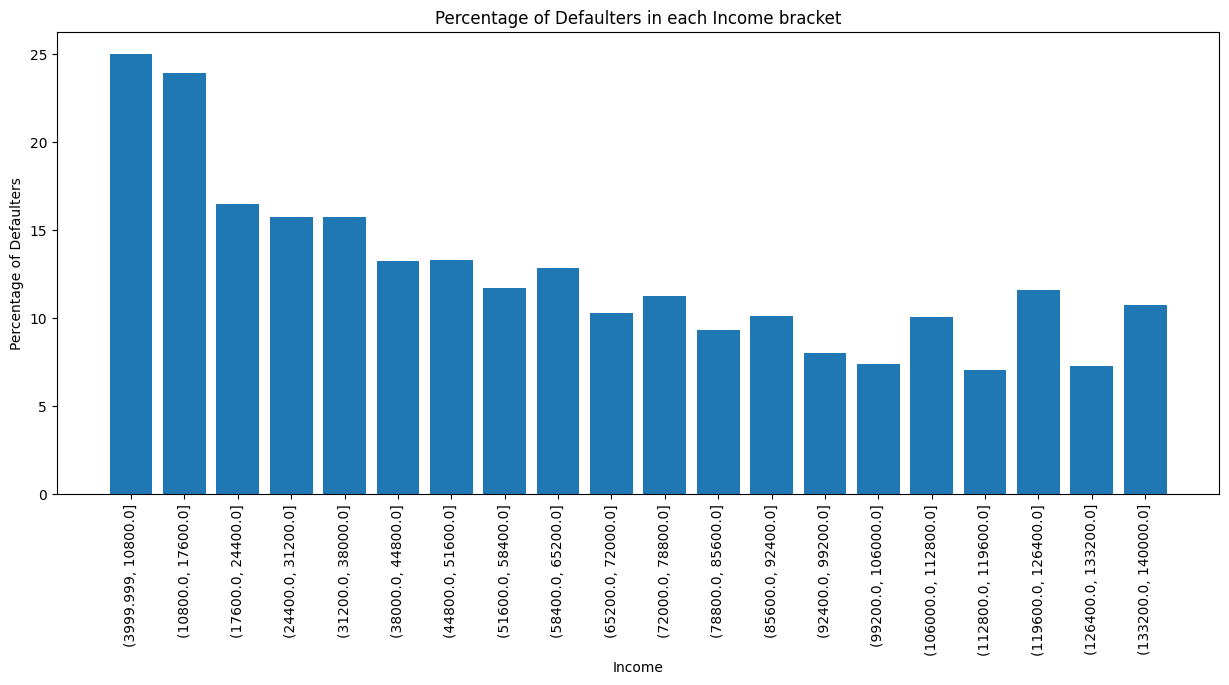

In [18]:
df = loans[loans['verification_status'] == 'Not Verified'][['loan_status', 'annual_inc']].dropna()

# Filter out the outliers
df_filtered = df

# Create bins for non-outlier income
bin_edges = np.linspace(df_filtered['annual_inc'].min(), df_filtered['annual_inc'].max(), 21)  # 10 bins
df_filtered['income_bin'] = pd.cut(df_filtered['annual_inc'], bins=bin_edges, include_lowest=True)

# Calculate the percentage of defaulters in each income bin
defaulter_percentage = df_filtered[df_filtered['loan_status'] == 'Charged Off'].groupby('income_bin').size() / df_filtered.groupby('income_bin').size() * 100

# print(defaulter_percentage)
# plot the bar chart
plt.bar(defaulter_percentage.index.astype(str), defaulter_percentage)
plt.xticks(rotation=90)
plt.xlabel('Income')
plt.ylabel('Percentage of Defaulters')
plt.title('Percentage of Defaulters in each Income bracket')
# increase plot width
plt.gcf().set_size_inches(15, 6)
plt.show()

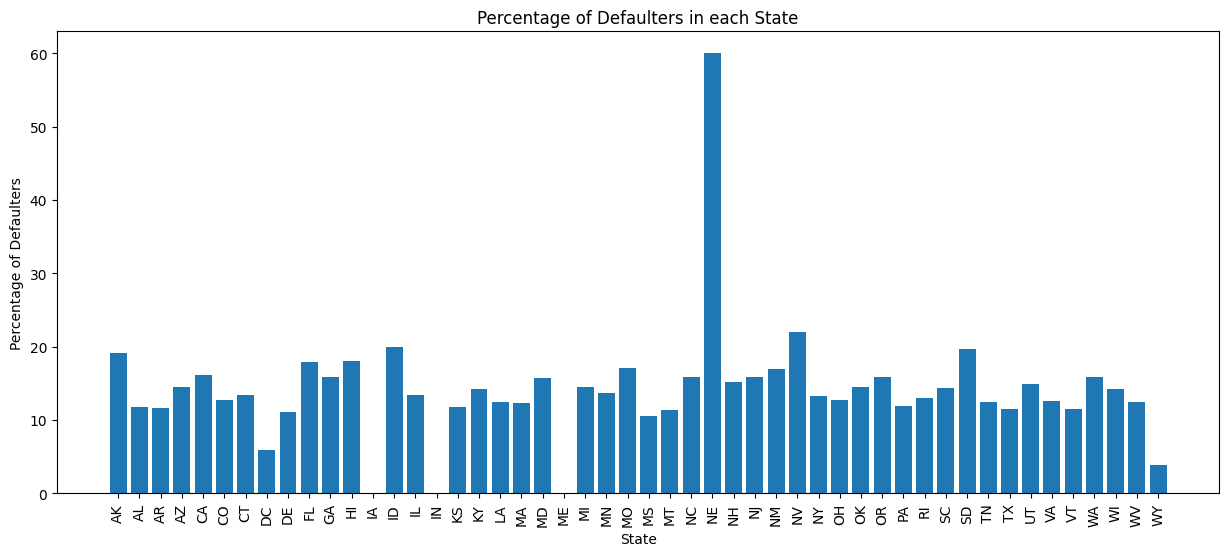

In [19]:
# show the percentage of defaulters in each state
defaulter_percentage = loans[loans['loan_status'] == 'Charged Off'].groupby('addr_state').size() / loans.groupby('addr_state').size() * 100

# plot the bar chart
plt.bar(defaulter_percentage.index.astype(str), defaulter_percentage)
plt.xticks(rotation=90)
plt.xlabel('State')
plt.ylabel('Percentage of Defaulters')
plt.title('Percentage of Defaulters in each State')
# increase plot width
plt.gcf().set_size_inches(15, 6)
plt.show()

In [20]:
df_defaulters = defaulter_percentage.reset_index()
df_defaulters.columns = ['state', 'percentage']

# filter by states where number of loans is greater than 10
df_defaulters = df_defaulters[df_defaulters['state'].isin(loans['addr_state'].value_counts()[loans['addr_state'].value_counts() > 10].index)]

fig = px.choropleth(df_defaulters, locations='state', color='percentage',
                    locationmode='USA-states', scope="usa",
                    title='Percentage of Loan Defaulters by State',
                    color_continuous_scale=px.colors.sequential.Reds,
                    labels={'percentage':'Percentage of Defaulters'}
                   )
fig.show()

In [21]:
# get null percentage for each column descending
null_percentage = loans.isnull().sum() / loans.shape[0] * 100
null_percentage.sort_values(ascending=False, inplace=True)
print(null_percentage)

print(loans['pub_rec_bankruptcies'].value_counts())

print(loans['loan_status'].value_counts())

mths_since_last_record     92.650272
mths_since_last_delinq     64.545404
desc                       32.345527
emp_title                   6.019271
emp_length                  2.795362
emp_length_num              2.795362
pub_rec_bankruptcies        1.843034
last_pymnt_d                0.193266
revol_util                  0.134446
title                       0.030811
last_credit_pull_d          0.005602
revol_bal                   0.000000
total_acc                   0.000000
total_pymnt                 0.000000
total_pymnt_inv             0.000000
total_rec_prncp             0.000000
total_rec_int               0.000000
total_rec_late_fee          0.000000
grade_sub_grade_num         0.000000
recoveries                  0.000000
collection_recovery_fee     0.000000
pub_rec                     0.000000
default                     0.000000
term_num                    0.000000
issue_month                 0.000000
issue_year                  0.000000
grade_num                   0.000000
s

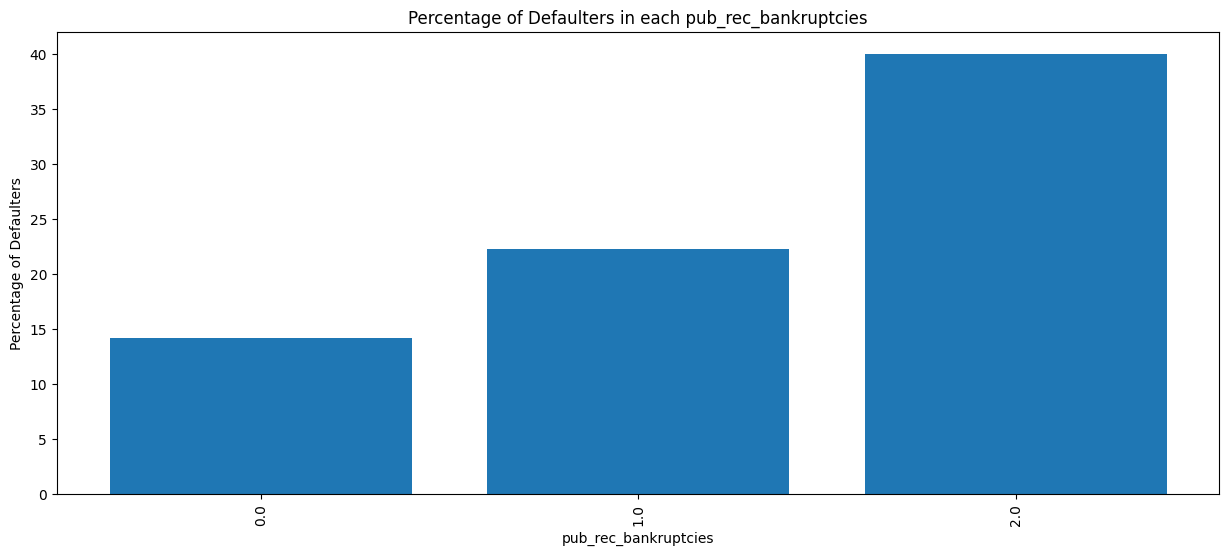

In [22]:
# draw default per pub_rec_bankruptcies, use default col
defaulter_percentage = loans[loans['loan_status'] == 'Charged Off'].groupby('pub_rec_bankruptcies').size() / loans.groupby('pub_rec_bankruptcies').size() * 100

# plot the bar chart
plt.bar(defaulter_percentage.index.astype(str), defaulter_percentage)
plt.xticks(rotation=90)
plt.xlabel('pub_rec_bankruptcies')
plt.ylabel('Percentage of Defaulters')
plt.title('Percentage of Defaulters in each pub_rec_bankruptcies')
# increase plot width
plt.gcf().set_size_inches(15, 6)
plt.show()


In [23]:
# show value counts for all categorical columns
for col in loans.select_dtypes(include=['object']).columns:
    print(loans[col].value_counts())

term
 36 months    27471
 60 months     8231
Name: count, dtype: int64
int_rate
10.99%    842
7.51%     764
11.49%    746
7.88%     702
13.49%    681
         ... 
16.15%      1
22.64%      1
17.54%      1
17.34%      1
15.01%      1
Name: count, Length: 370, dtype: int64
grade
B    10903
A     9568
C     7332
D     4692
E     2207
F      777
G      223
Name: count, dtype: int64
sub_grade
A4    2708
B3    2593
A5    2576
B5    2441
B4    2290
C1    1920
B2    1884
C2    1794
A3    1744
B1    1695
A2    1443
C3    1397
D2    1195
C4    1151
A1    1097
C5    1070
D3    1033
D1     877
D4     836
D5     751
E1     610
E2     518
E3     434
E4     356
E5     289
F1     239
F2     193
F3     138
F4     124
F5      83
G1      70
G2      57
G4      40
G3      35
G5      21
Name: count, dtype: int64
emp_title
US Army                                     120
Bank of America                             104
AT&T                                         55
US Air Force                               